### 観測データ
解析に必要なデータ
- XFFTS data
- Encoder data
- weather status
- hosei copy
- obs copy


### 解析フロー

- doppler tracking[x]
- Chopper Wheel [o]
- baseline fitting [o]
- Scaling(from standard object?) [x]
- regrid [o]
    - rms [o]
    - distance [o]
- +header [o]
- 3d-fits[o]

### memo
備忘録
- astropy unitを駆使してわかりやすく書くべき（arcsec/degでバグを増やさないために）
- あらかじめxfftsの分光データをra,dec対応させておく

        
 観測データについて
 - 解析に必要なファイルは？
    - XFFTS分光データ ndf
    - エンコーダ .db
        - あらかじめfk5, galactic に変換して一時ファイルに保存する必要 (npy)
    - weather .???
        - これをどの形式にするか考え中 csv , db
    - 観測時に使用した器差パラメータの入ったファイル hosei_230.txt + alpha
        - これの仕様を早く決定しなくては
        
 これらの複数のファイルをどうやってひとまとめにするか考える必要あり
 - necrecに接続したHDD にndfファイルは保存される
 - その他は全て観測pc
     - nfs mount で観測終了時にHDDにcopyする
     
 - necrec HDD
   - /home/amigos/data/[observation name]/yyyymmhh_HHMMSS/

In [122]:
!ls /home/amigos/data/otf_2019
import time
start_time = time.time()

0727test.db			    test2.db	test6.hdf5
n20190824043335_12CO_2-1_otf_OriKL  test2.hdf5	test.db
n20190824043539_12CO_2-1_otf_OriKL  test3.dat	test.hdf5
n20190824043706_12CO_2-1_otf_OriKL  test3.hdf5	testwrite.dat
n20190824070836_12CO_2-1_otf_OriKL  test4.dat	testwrite.txt
n20190824071829_12CO_2-1_otf_OriKL  test4.hdf5	write_test.py
n20190824074527_12CO_2-1_otf_OriKL  test5.dat	write_test.py~
n20190824075446_12CO_2-1_otf_OriKL  test5.hdf5
test01.dat			    test6.dat


In [123]:
#radec 変換データ作成
#! python analy_coordinates.py
import sys
sys.path.append("../script/")
import subprocess
import os

In [245]:
#analy_dir = "/home/amigos/data/otf_2019/n20190824043706_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824070836_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824071829_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824074527_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824075446_12CO_2-1_otf_OriKL"
#analy_dir = "/home/amigos/data/otf_2019/n20190824081542_12CO_2-1_otf_OriKL"
analy_dir = "/home/amigos/data/otf_2019/n20190824083421_12CO_2-1_otf_OriKL"
subprocess.getoutput(["ls {}".format(analy_dir)]).split("\n")

['enc.db',
 'enc.db-journal',
 'encoder_radec.npy',
 'hosei_230.txt',
 'otf_test3y.obs',
 'weather.csv',
 'xffts.ndf',
 'xffts_radec.npy']

In [242]:
%%time
!python /home/amigos/git/analy_n2data/script/analy_coordinates.py  /home/amigos/data/otf_2019/n20190824083421_12CO_2-1_otf_OriKL

100%|███████████████████████████████████| 1687/1687 [00:00<00:00, 186839.29it/s]
2019-08-24 08:58:43 : read_end
2019-08-24 08:58:43 : indexing end
2019-08-24 08:58:43 : hokan
Az [-93.20166412 -93.20181593 -93.20200004 ... -92.8345484  -92.8345484
 -92.8345484 ]
El [57.93825647 57.93783702 57.93738673 ... 57.17871448 57.17871448
 57.17871448]
[[5369.03539774 5369.03539686 5369.03539592 ... 5369.03386083
  5369.03386083 5369.03386083]
 [6707.6300971  6707.63010034 6707.63010388 ... 6707.63425103
  6707.63425103 6707.63425103]]
2019-08-24 08:58:45 : coordinate trans end
2019-08-24 08:58:45 : coordinate calc start
Az [-92.09239509 -92.09239509 -92.09239509 ... -92.8345484  -92.8345484
 -92.8345484 ]
El [59.0584187  59.0584187  59.0584187  ... 57.17871448 57.17871448
 57.17871448]
[[5369.03780115 5369.03780115 5369.03780115 ... 5369.03386083
  5369.03386083 5369.03386083]
 [6707.61954405 6707.61954405 6707.61954405 ... 6707.63425103
  6707.63425103 6707.63425103]]
2019-08-24 08:59:00 : coor

In [243]:
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
from astropy.io import fits
###以下独自
import n2df
import read_obsfile
import doppler_nanten

In [246]:
###AzEl情報をradecに変換したものの一時ファイルの読み込み
path_to_xffts_c = os.path.join(analy_dir, "xffts_radec.npy")
path_to_encoder_c = os.path.join(analy_dir, "encoder_radec.npy")
xffts = numpy.load(path_to_xffts_c)
encoder = numpy.load(path_to_encoder_c)

In [247]:
###-30 == 330deg なので。この辺どうしようかね？
#xffts[0] = xffts[0]-360

### gridの作成


In [248]:
#観測プログラムから必要な情報を出す
obsfile_dict = read_obsfile.read(os.path.join(analy_dir, "otf_test3y.obs"))
lamda_on = obsfile_dict["lambda_on"]
beta_on = obsfile_dict["beta_on"]
N = obsfile_dict["N"]
grid = obsfile_dict["grid"]/3600 #[deg]

In [249]:
print(lamda_on)
print(beta_on)
print(N)
print(grid)

0.80613
-20.37432
9
0.008333333333333333


In [250]:
#今回girdからどこまで離れた範囲まで解析の中に含めるかの値。これは外からいじれる値にしておかないと
offset = 80#半径[arcsec]
array_num = 2#1~16IF 

In [251]:
#make gird
ragrid = numpy.arange(lamda_on - ((N-1)/2)*grid, lamda_on + ((N-1)/2+1)*grid, grid)
decgrid = numpy.arange(beta_on - ((N-1)/2)*grid, beta_on + ((N-1)/2+1)*grid, grid)
radec_grid = numpy.meshgrid(ragrid, decgrid)

In [252]:
plt.plot(radec_grid[0], radec_grid[1])

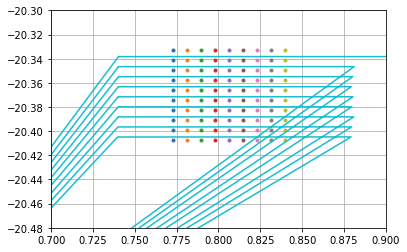

In [255]:
#gridの確認
#girdとXFFTSの点がずれている。これはプロジェクションの問題でcosがかかっていないからか？
plt.plot(radec_grid[0], radec_grid[1], ".")
plt.plot(xffts[0], xffts[1])
#plt.plot(encoder[0], encoder[1], ".")
plt.xlim(0.7,0.9)
plt.ylim(-20.48, -20.3)
plt.savefig("neko.pdf")
plt.grid()
plt.show()

In [256]:
a = -20.40
b = -20.33
c = 0.725
d = 0.79
print(a-b)
print(c-d)
grid*9

-0.07000000000000028
-0.06500000000000006


0.075

## doppler tracking


In [257]:
#this will be added

### 分光データの読み出し
on/off/hot indexの整理

In [258]:
%%time
n = n2df.Read(os.path.join(analy_dir, "xffts.ndf"))
array_data = n.read_onearray(array_num)#1IFの分光データ
obs_mode = n.read_obs_mode()#観測モード（ON/OFF/HOT）
scan_num = n.read_scan_num()#スキャンライン（0,1,2,3,4,...）
###array_data, scan_num, obs_mode = n.read_for_otf(1)#3分くらいかかた

100%|██████████| 1687/1687 [00:00<00:00, 557719.78it/s]

CPU times: user 44 ms, sys: 88 ms, total: 132 ms
Wall time: 1.03 s


In [259]:
###index探し
obs_mode = numpy.array(obs_mode)
scan_num = numpy.array(scan_num)

offmask = obs_mode == "OFF"
offindex = numpy.where(offmask == True)

hotmask = obs_mode == "HOT"
hotindex = numpy.where(hotmask == True)

onmask = obs_mode == "ON"
onindex = numpy.where(onmask == True)

max_scannum = numpy.max(scan_num)#Caution! scan num starts from 0, so scan number of 26 indicates 27 times scan

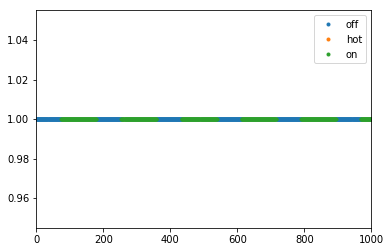

In [260]:
#一応indexの可視化
plt.plot(offindex[0], [1]*len(offindex[0]),"." , label = "off")
plt.plot(hotindex[0], [1]*len(hotindex[0]),"." , label = "hot")
plt.plot(onindex[0], [1]*len(onindex[0]),"." , label = "on")
plt.xlim(0,1000)
plt.legend()
plt.show()

[0 0 0 ... 9 9 9]


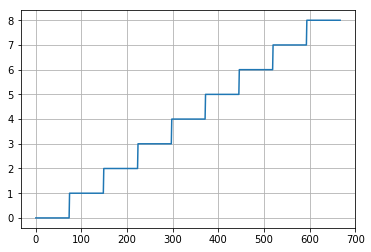

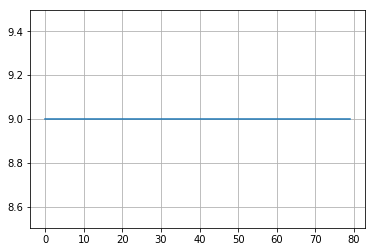

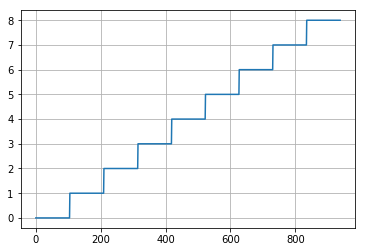

In [261]:
#OFF 点のscan number を取得
scan_num = numpy.array(scan_num)
print(scan_num)
offindex[0]
plt.plot(scan_num[offindex[0]])
plt.grid()
plt.show()

#HOT 点のscan number を取得
scan_num = numpy.array(scan_num)
hotindex[0]
plt.plot(scan_num[hotindex[0]])
plt.grid()
plt.show()

# ON 点のscan number を取得
scan_num = numpy.array(scan_num)
plt.plot(scan_num[onindex[0]])
plt.grid()
plt.show()

### hot/offの積分

In [262]:
#HOT積分
print(numpy.unique(scan_num[hotindex[0]]))#HOT のscan number
hotnum = numpy.unique(scan_num[hotindex[0]])#HOTの数

hotdata = []

for i in tqdm(hotnum):#i = scan number
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], hotindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]
    ###
    mm = index[0][c]#scan numの値でフィルターしたhot
    #print(mm)
    ###積分
    tmp = [array_data[j] for j in mm]
    hotdata.append(sum(tmp)/len(tmp))
    pass

#下は擬似データの質が低いための処理。将来的に削除
hotdata = numpy.array(hotdata)
hotdata = hotdata + 5000

100%|██████████| 1/1 [00:00<00:00, 220.25it/s]

[9]


In [263]:
##OFFの積分
print(numpy.unique(scan_num[offindex[0]]))#HOT のscan number
offnum = numpy.unique(scan_num[offindex[0]])#HOTの数

offdata = []
scan_num = numpy.array(scan_num)

for i in tqdm(offnum):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], offindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    offdata.append(sum(tmp)/len(tmp))

100%|██████████| 9/9 [00:00<00:00, 532.08it/s]

[0 1 2 3 4 5 6 7 8]


Hot のデータはscan line分あるわけでないので補完
Off もscan line 分ある観測プログラムしかないはずだが、一応補完

補完の方法は次のOFF/HOTの点の観測を行うまでは直近のデータを採用する形

In [264]:
d = numpy.unique(scan_num[hotindex[0]])#HOT のscan number
hotdata_ = []
count = 0

for i in tqdm(range(max_scannum)):
        #print(i,count)
        if i == d[count]:
            hotdata_.append(d[count])
            count +=1
        elif i < d[count]:
            hotdata_.append(d[count])
        else:#この例外には入らないはず
            print(i)

100%|██████████| 9/9 [00:00<00:00, 29172.13it/s]


In [265]:
d = numpy.unique(scan_num[offindex[0]])#HOT のscan number
offdata_ = []
count = 0

for i in tqdm(range(max_scannum)):
        #print(i,count)
        if i == d[count]:
            offdata_.append(d[count])
            count +=1
        elif i < d[count]:
            offdata_.append(d[count])
        else:#この例外には入らないはず
            print(i)

100%|██████████| 9/9 [00:00<00:00, 12433.71it/s]


In [266]:
# ###Choper wheel

@numba.jit
def chopper_wheel(on_index, scan_num, temprature = 300):    
    #scan_num = n[on_index]["scan_num"]
    #Tastar = (array_data[on_index] - offdata[scan_num])/(hotdata[scan_num] - offdata[scan_num]) * temprature
    Tastar = (array_data[on_index] - offdata[0])/(hotdata[0] - offdata[0]) * temprature#test, this will be deleted（追記：hotdataとoffdataの補完部分作ってないからかな？）
    return Tastar

def calc(i):#on点をscan indexでmaskしchopper wheelする
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
    c = numpy.intersect1d(index[0], onindex[0])
    return [[j, chopper_wheel(j, i)] for j in c]###j= index 

In [267]:
ondata = [calc(i) for i in tqdm(range(max_scannum+1))]#Chopper Wheelしたやつ

100%|██████████| 10/10 [00:01<00:00,  7.18it/s]


In [268]:
%%time
data_on = {ondata[i][j][0]:ondata[i][j][1] for i in range(len(ondata)) for j in range(len(ondata[i]))}###d[onindex] = onarray
data_on[4433][16000] += 100000000
print(data_on[4433][16000])

KeyError: 4433

In [269]:
#距離による重みつけ関数１
#sigma == ビームサイズ
def gauss(x, a = 1, mu = 0, sigma = 160):
    return a * numpy.exp(-(x - mu)**2 / (2*sigma**2))


#距離による重みつけ関数2 関数系わからないので今はgaussianだけど修正
def bessel_gauss(x, a = 1, mu = 0, sigma = 160):
    return a * numpy.exp(-(x - mu)**2 / (2*sigma**2))

#球面なのでRA方向の長さがDECで変わります。なのでRA-DEC平面での距離(角度)を出すには、RAをcos(DEC)で割る必要があります。
def calc_distance(d1, d2):
    #d1 = [ra, dec] #deg   
    factor = 3600#こういうことしなくてもいいようにastropy unitを使う（要編集）
    d1[0] = d1[0]*factor
    d1[1] = d1[1]*factor
    d2[0] = d2[0]*factor
    d2[1] = d2[1]*factor
    return ((d1[0] - d2[0])**2 + (d1[1] - d2[1])**2)**0.5

def calc_rms(arr):
    return numpy.sqrt(numpy.mean(arr**2))

def rms_dist_weighting(arr, dist, rms):
    return [arr*gauss(dist)*(rms**-2), gauss(dist)*(rms**-2)]

## Baseline fitting

In [270]:
#baseline fitting parameter
center = 8000
width = 1000
start = 3000
end = 30000

#baseline fitting function
def f(x, a, b, c):
    return a*x**2 + b*x + c

def  baseline_fitting(arr_x, arr_y, index1, index2, index3, index4):
    tmpdata_y1 = arr_y[index1:index2]
    tmpdata_y2 = arr_y[index3:index4]
    tmpdata_x1 = arr_x[index1:index2]
    tmpdata_x2 = arr_x[index3:index4]
    x = numpy.concatenate([tmpdata_x1, tmpdata_x2])
    y = numpy.concatenate([tmpdata_y1, tmpdata_y2])
    param = numpy.polyfit(x, y, 2)
    arr_y = arr_y - f(arr_x, *param)
    return arr_y
    
#ch
xindex = numpy.linspace(0, 32768, 32768)

#baseline fitting index
index1 = int(start)
index2 = int(center - width/2)
index3 = int(center + width/2)
index4 = int(end)
print(index1, index2, index3, index4)

testoffset = numpy.linspace(1, 32768, 32768)

for i in tqdm(data_on.keys()):
    data_on[i] = data_on[i] + testoffset#ベースラインフィッティングできているかの確認のため
    origin = data_on[i]#for debug, this will be deleted
    data_on[i] = baseline_fitting(data_on[i], xindex, index1, index2, index3, index4)
    
    
plt.plot(data_on[i], label="after chopper wheel")#after chopper wheel
plt.plot(origin, label="before chopper wheel")#before chopper wheel
plt.legend()
plt.grid()

  3%|▎         | 30/939 [00:00<00:03, 293.11it/s]

3000 7500 8500 30000


100%|██████████| 939/939 [00:02<00:00, 341.12it/s]


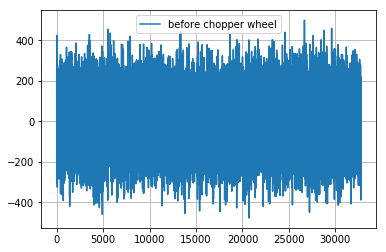

In [271]:
#plt.plot(data_on[i], label="after chopper wheel")#after chopper wheel
%matplotlib inline
plt.plot(origin-testoffset, label="before chopper wheel")#before chopper wheel
plt.legend()
plt.grid()

## grid内のデータ探索

あるgridに採用するデータのindexを求める

In [275]:
%time
index_list = []
for i in tqdm(range(max_scannum)):
    for j in range(max_scannum):
       # print(ragrid[i], decgrid[j])
        index1 = numpy.where((ragrid[i]-(offset/3600)<xffts[0]) & ((ragrid[i] + (offset/3600)>xffts[0])))
        index2 = numpy.where((decgrid[j]-(offset/3600)<xffts[1]) & ((decgrid[j] + (offset/3600)>xffts[1])))
        index_ = [i in index2[0] for i in index1[0]]
        index_ = numpy.array(index_)
        index_1and2 = numpy.where(index_ == True)
        index_1and2 = index1[0][index_1and2]
        index_list.append(index_1and2)


100%|██████████| 9/9 [00:00<00:00, 105.51it/s]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.58 µs


### xfftsデータの確認

### データをgridに入れる

本番はもう少し賢く書くけど、ひとまず

In [288]:
%%time
#cubeデータの作成
#data_c = numpy.zeros((31, 31, 32768))#(ra, dec, ch)
#index_list2 = numpy.reshape(index_list, (31,31))#index listの2次元化（これは前処理しておく） #これは正しいか？
data_c = numpy.zeros((max_scannum, max_scannum, 32768))#(ra, dec, ch)
index_list2 = numpy.reshape(index_list, (max_scannum, max_scannum))#index listの2次元化（これは前処理しておく） #これは正しいか？

## Chopper wheelしたデータをdatacubeに入れる
for i in tqdm(range(max_scannum)):#ra
    for j in range(max_scannum):#dec
        try:
            numerator_list = []#分子
            denominator_list= []#分母
            for k in index_list2[i][j]:
                dist = calc_distance([ragrid[i], decgrid[j]], [xffts[0][k], xffts[1][k]])
                rms = calc_rms(data_on[k])
                weighted_data = rms_dist_weighting(data_on[k], dist, rms)
                #weighted_data = rms_dist_weighting(data_on[k], dist, 1)###RMSがうまく動いているかの確認
                numerator_list.append(weighted_data[0])
                denominator_list.append(weighted_data[1])
            data_c[i][j] = sum(numerator_list)/sum(denominator_list)
        except Exception as e:
            print("[{},{}], {}".format(i,j,e), end = "")

100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

CPU times: user 2.29 s, sys: 16 ms, total: 2.31 s
Wall time: 2.48 s


距離を考慮すると...

### astropyでfitsに書き出す

In [289]:
#3軸の入れ替え。
data_c = numpy.swapaxes(data_c, 0,2)
print(numpy.shape(data_c))#軸の入れ替えの確認

(32768, 9, 9)


ヘッダーの作成

In [290]:
header_dict = {
"object" : obsfile_dict["object"],
"crval1" : obsfile_dict["lambda_on"],
"cdelt1" : obsfile_dict["grid"]/3600,
"crpix1" : obsfile_dict["N"]-1/2,#中心ピクセル
"crval2" : obsfile_dict["beta_on"],
"cdelt2" : obsfile_dict["grid"]/3600,
"crpix2" : obsfile_dict["N"]-1/2 #中心ピクセル
}

In [291]:
temp = """
SIMPLE  =                    T                                                  
BITPIX  =                  -64                                                  
NAXIS   =                    3                                                  
NAXIS1  =                  31                                                 
NAXIS2  =                  31                                                 
NAXIS3  =                   32768                                                  
OBJECT  = '{object}              '                                                  
TELESCOP= 'NANTEN2            '                                                  
INSTRUME= 'MULT2-11          '                                                  
OBSERVER= 'z7510rk           '                                                  
DATE-OBS= '2007-12-30        '                                                  
DATE-MAP= '2012-01-19        '                                                  
BSCALE  =    0.10000000000E+01                                                  
BZERO   =    0.00000000000E+01                                                  
BUNIT   = 'K                 '                                                  
EPOCH   =    0.20000000000E+04                                                  
OBSRA   =    8.38104170000E+01                                                  
OBSDEC  =   -5.37511100000E+00                                                  
DATAMAX =    1.16774444580E+02                                                  
DATAMIN =   -8.33924560547E+01                                                  
CTYPE1  = 'RA---GLS          '                                                  
CRVAL1  =    {crval1}                                                  
CDELT1  =    {cdelt1}                                                  
CRPIX1  =      {crpix1}
CROTA1  =     0.0000000000E+00                                                  
CTYPE2  = 'DEC--GLS          '                                                  
CRVAL2  =   {crval2}                                                  
CDELT2  =   {cdelt2}                                               
CRPIX2  =     {crpix2}                                               
CROTA2  =     0.0000000000E+00                                                  
CTYPE3  = 'VELO-LSR          '                                                  
CRVAL3  =    2.50000000000E+02                                                  
CDELT3  =    5.00000000000E+02                                                  
CRPIX3  =    1.00000000000E+00                                                  
CROTA3  =    0.00000000000E+00                                                  
BLANK   =   -1.00000000000E+00 """.format(**header_dict)

In [292]:
target_header = fits.Header.fromstring(temp, sep = "\n")

In [293]:
#書き出し
hdu = fits.PrimaryHDU(data_c, target_header)
hdulist = fits.HDUList([hdu])
hdulist.writeto("test4.fits", overwrite = True)

In [294]:
##読み込み
hdu_list = fits.open("test4.fits")
hdu_r = hdu_list[0]
data = hdu_r.data
header = hdu_r.header

In [295]:
#解析にかかった時間を出すため
print("required time : {}".format(time.time() - start_time))

required time : 3800.3916099071503


In [296]:
#%matplotlib notebook
%matplotlib inline
from ipywidgets import interact

def plot(i):
    plt.figure(figsize=(8, 8))
    plt.imshow(data[i].T, cmap = "gist_rainbow")
    #plt.xlabel("ra")
    #plt.ylabel("dec")
    plt.show()


interact(plot, i = (0,16000,1))

A Jupyter Widget

<function __main__.plot>

In [287]:
#bokeh  使い方あんまかしわからん
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

output_notebook()
plt1 = figure()
rend1 = plt1.image(image=[data[16000]], x=0, y=0, dw =31, dh=31, palette="Plasma11")

show(plt1)

Loading BokehJS ...

In [ ]:
numpy.max(data)

In [ ]:
numpy.where(data > 213)